#Please ignore the Transformer and Moving Average code parts. My code begins from the CNN part.

In [1]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from keras.models import load_model
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')


Tensorflow version: 2.9.2


## Hyperparameters

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
batch_size = 32
seq_len = 128

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

## Load Bitcoin data

In [3]:
Bit_coin = 'BTC-USD.csv'

df = pd.read_csv(Bit_coin, delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('Date', inplace=True)
df.tail()

,Date,Open,High,Low,Close,Volume
3003,2022-12-07,17089.505859,17109.376953,16750.558594,16848.126953,19675404389
3004,2022-12-08,16847.349609,17267.916016,16788.783203,17233.474609,20496603770
3005,2022-12-09,17232.148438,17280.546875,17100.835938,17133.152344,20328426366
3006,2022-12-10,17134.220703,17216.826172,17120.683594,17128.724609,12706781969
3007,2022-12-11,17133.619141,17188.718750,17132.080078,17165.578125,12709837824


## Plot daily Bitcoin closing prices and volume

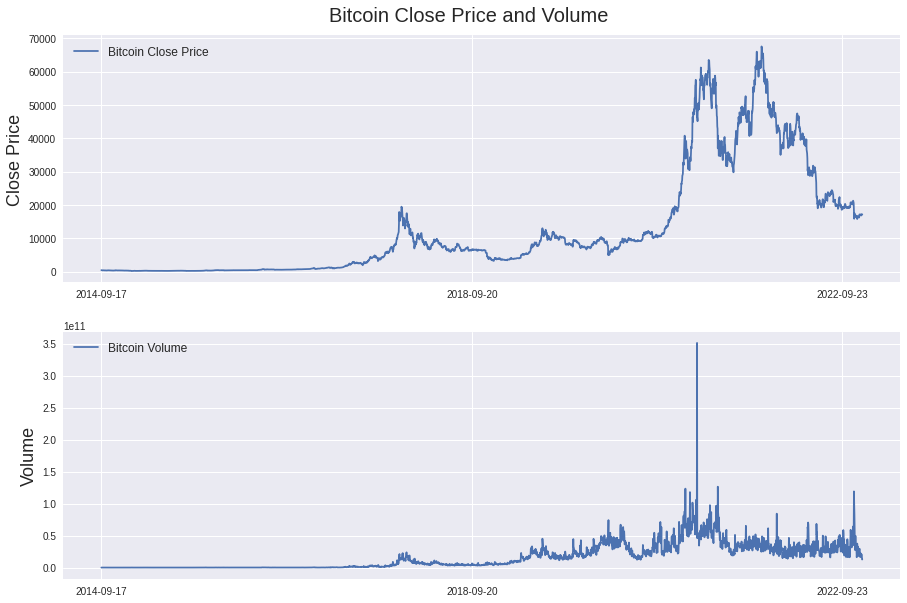

In [4]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Bitcoin Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label='Bitcoin Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['Date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label='Bitcoin Volume')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['Date'].loc[::1464])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

## Calculate normalized percentage change of all columns

In [5]:
'''Calculate percentage change'''

df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

###############################################################################
'''Normalize price columns'''
#
min_return = min(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df[(df.index < last_20pct)]['Volume'].min(axis=0)
max_volume = df[(df.index < last_20pct)]['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Create training, validation and test split'''

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (2406, 5)
Validation data shape: (301, 5)
Test data shape: (300, 5)


,Open,High,Low,Close,Volume
1,0.564541,0.556789,0.456272,0.480272,0.238866
2,0.480633,0.493720,0.484696,0.483609,0.153585
3,0.484328,0.578509,0.617801,0.652758,0.133372
4,0.649951,0.554364,0.609059,0.556000,0.093565
5,0.560231,0.574102,0.611598,0.608887,0.123160


## Plot daily changes of close prices and volume

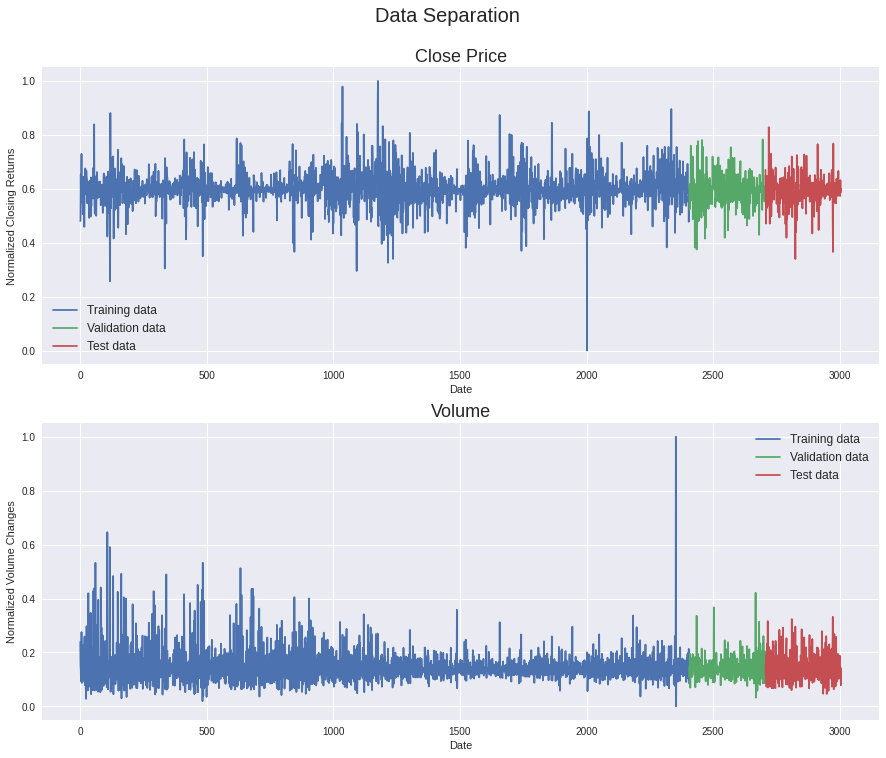

In [6]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

## Create chunks of training, validation and test data

In [7]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (2278, 128, 5) (2278,)
Validation set shape (173, 128, 5) (173,)
Testing set shape (172, 128, 5) (172,)


## TimeVector

In [3]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config
  

## Transformer

In [4]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config          

## Model

In [5]:
def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, 5))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model


model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, verbose=1)

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=35, 
                    callbacks=[callback],
                    validation_data=(X_val, y_val))  

model = tf.keras.models.load_model('/content/Transformer+TimeEmbedding.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})


###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='Bitcoin Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted Bitcoin Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('Bitcoin Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='Bitcoin Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted Bitcoin Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('Bitcoin Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='Bitcoin Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted Bitcoin Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('Bitcoin Closing Returns')
ax31.legend(loc="best", fontsize=12)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 5)]     0           []                               
                                                                                                  
 time2_vector (Time2Vector)     (None, 128, 2)       512         ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 128, 7)       0           ['input_1[0][0]',                
                                                                  'time2_vector[0][0]']           
                                                                                                  
 transformer_encoder (Transform  (None, 128, 7)      99114       ['concatenate[0][0]',        

NameError: ignored

## Model metrics

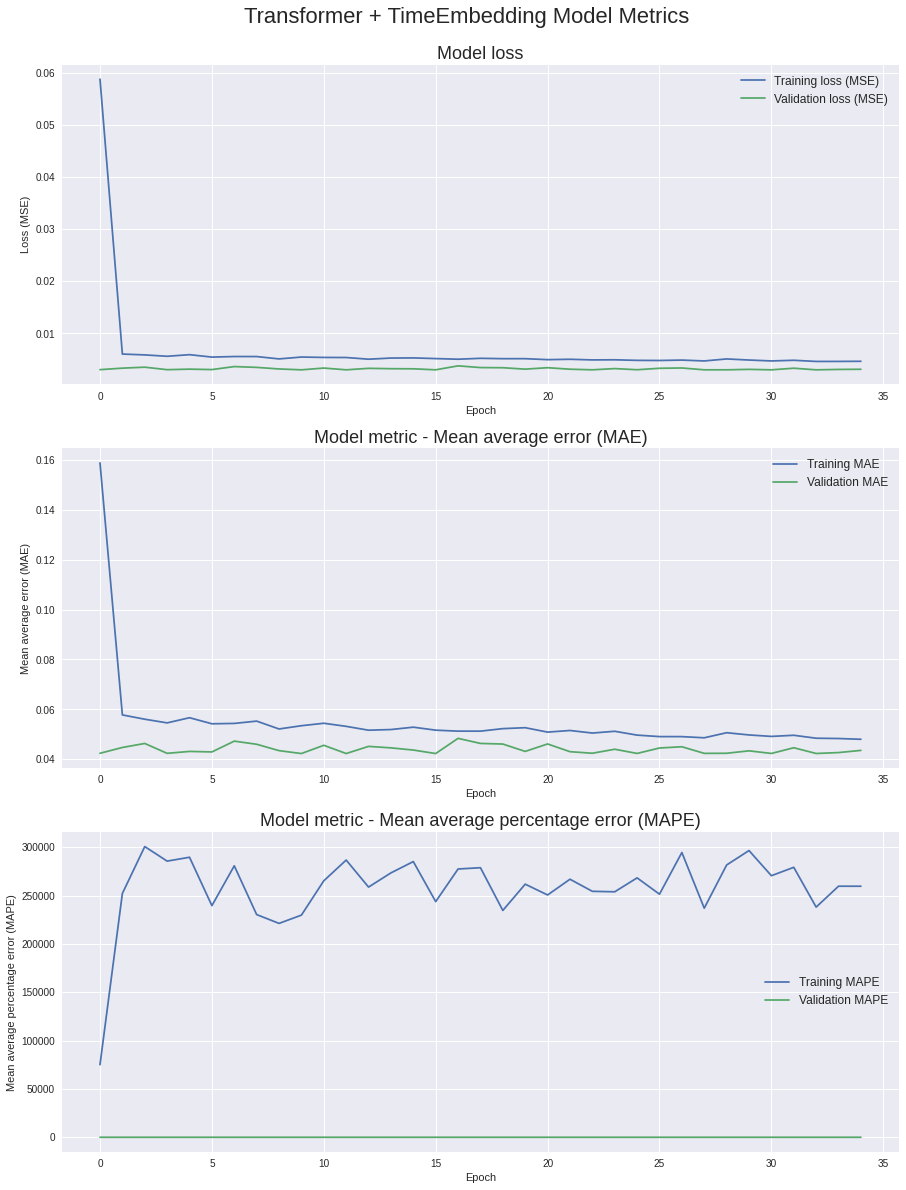

In [ ]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)

## Model architecture overview

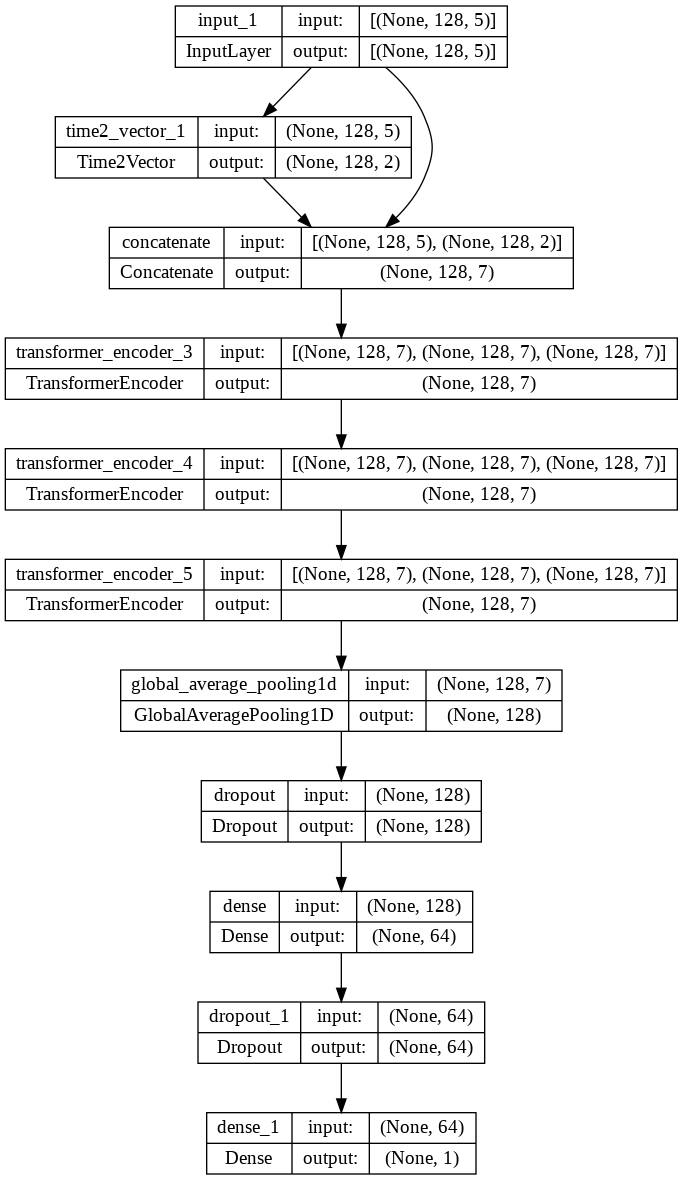

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="Bitcoin_Transformer+TimeEmbedding.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96,)

# Moving Average

## Moving Average - Load Bitcoin data again, to apply rolling window

In [6]:
Bitcoin_path = 'BTC-USD.csv'

df = pd.read_csv(Bitcoin_path, delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('Date', inplace=True)

print(df.shape)

# Apply moving average with a window of 10 days to all columns
df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].rolling(10).mean() 

# Drop all rows with NaN values
df.dropna(how='any', axis=0, inplace=True) 
print(df.shape)
df.head()

(3008, 6)
(2999, 6)


,Date,Open,High,Low,Close,Volume
9,2014-09-26,422.111301,431.163394,405.705799,416.144199,30503340.0
10,2014-09-27,415.880499,425.008292,400.200800,410.362796,29900590.0
11,2014-09-28,410.141601,419.423993,396.323599,405.636896,28813600.0
12,2014-09-29,405.424103,415.161594,395.094397,403.703998,28271400.0
13,2014-09-30,403.565604,411.929694,393.450397,401.507999,28055770.0


## Moving Average - Plot daily Bitcoin closing prices and volume

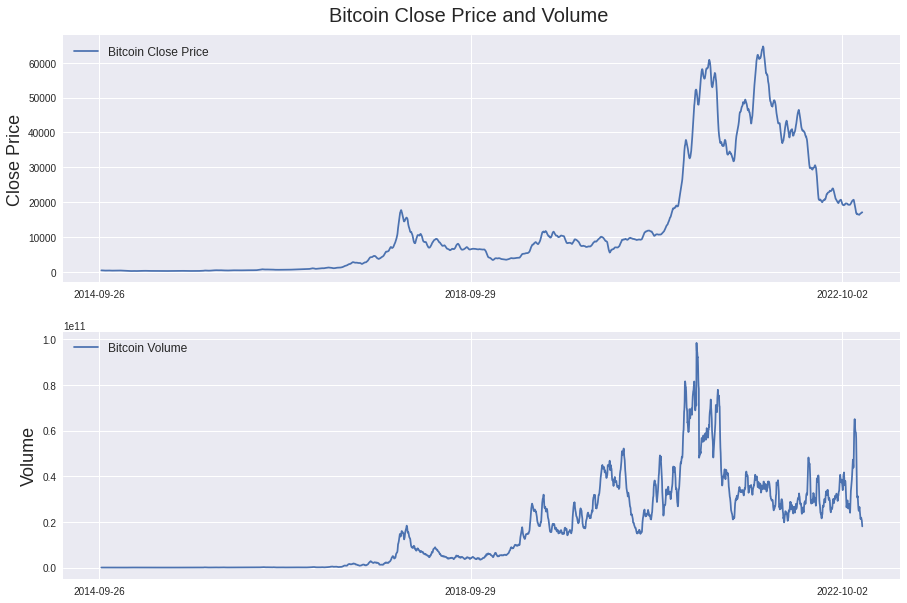

In [7]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Bitcoin Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label='Bitcoin Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['Date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label='Bitcoin Volume')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['Date'].loc[::1464])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

## Moving Average - Calculate normalized percentage change for all columns

In [8]:
'''Calculate percentage change'''

df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

###############################################################################
'''Normalize price columns'''
#
min_return = min(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df[(df.index < last_20pct)]['Volume'].min(axis=0)
max_volume = df[(df.index < last_20pct)]['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Create training, validation and test split'''

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (2399, 5)
Validation data shape: (300, 5)
Test data shape: (299, 5)


,Open,High,Low,Close,Volume
10,0.365537,0.369061,0.374190,0.371839,0.474435
11,0.372517,0.377308,0.402358,0.389088,0.452937
12,0.389191,0.398915,0.450167,0.438092,0.475657
13,0.439406,0.416174,0.442477,0.433196,0.490155
14,0.435524,0.435593,0.449802,0.445190,0.498417


In [28]:
df.shape

(2998, 6)

## Moving Average - Plot daily changes of close price and volume

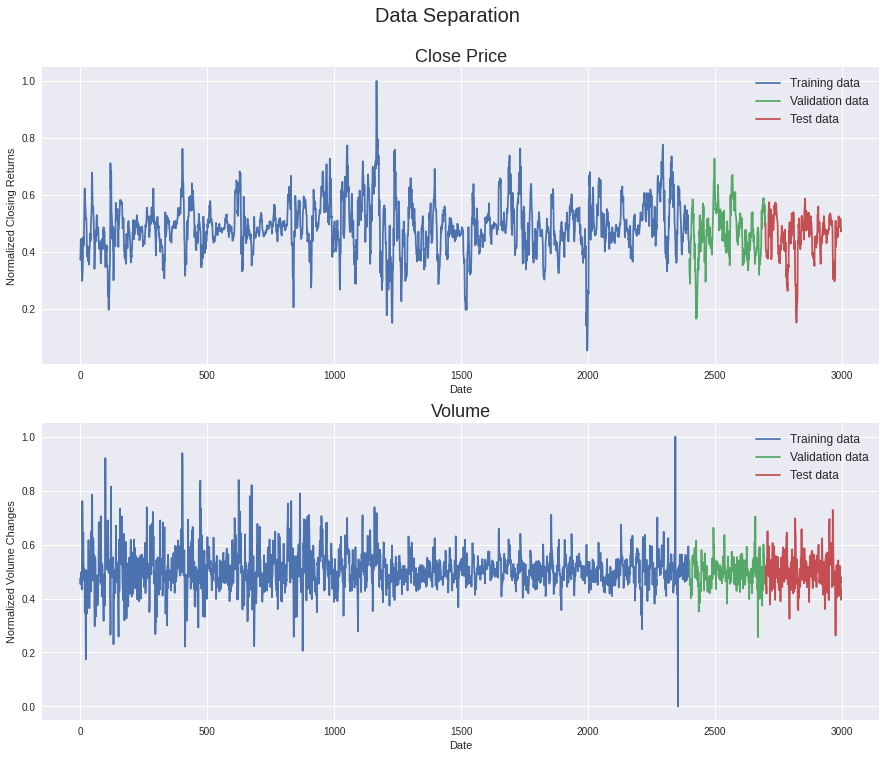

In [9]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

## Moving Average - Create chunks of training, validation, and test data

In [10]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2271, 128, 5) (2271,)
(172, 128, 5) (172,)


## Moving Average - Model

In [ ]:
def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, 5))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model


model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, 
                                              verbose=1)

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=35, 
                    callbacks=[callback],
                    validation_data=(X_val, y_val))  

model = tf.keras.models.load_model('/content/Transformer+TimeEmbedding.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})


###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='Bitcoin Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted Bitcoin Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('Bitcoin Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='Bitcoin Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted Bitcoin Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('Bitcoin Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='Bitcoin Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted Bitcoin Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('Bitcoin Closing Returns')
ax31.legend(loc="best", fontsize=12)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 5)]     0           []                               
                                                                                                  
 time2_vector_1 (Time2Vector)   (None, 128, 2)       512         ['input_2[0][0]']                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 128, 7)       0           ['input_2[0][0]',                
                                                                  'time2_vector_1[0][0]']         
                                                                                                  
 transformer_encoder_3 (Transfo  (None, 128, 7)      99114       ['concatenate_1[0][0]',    

## Moving Average - Model metrics

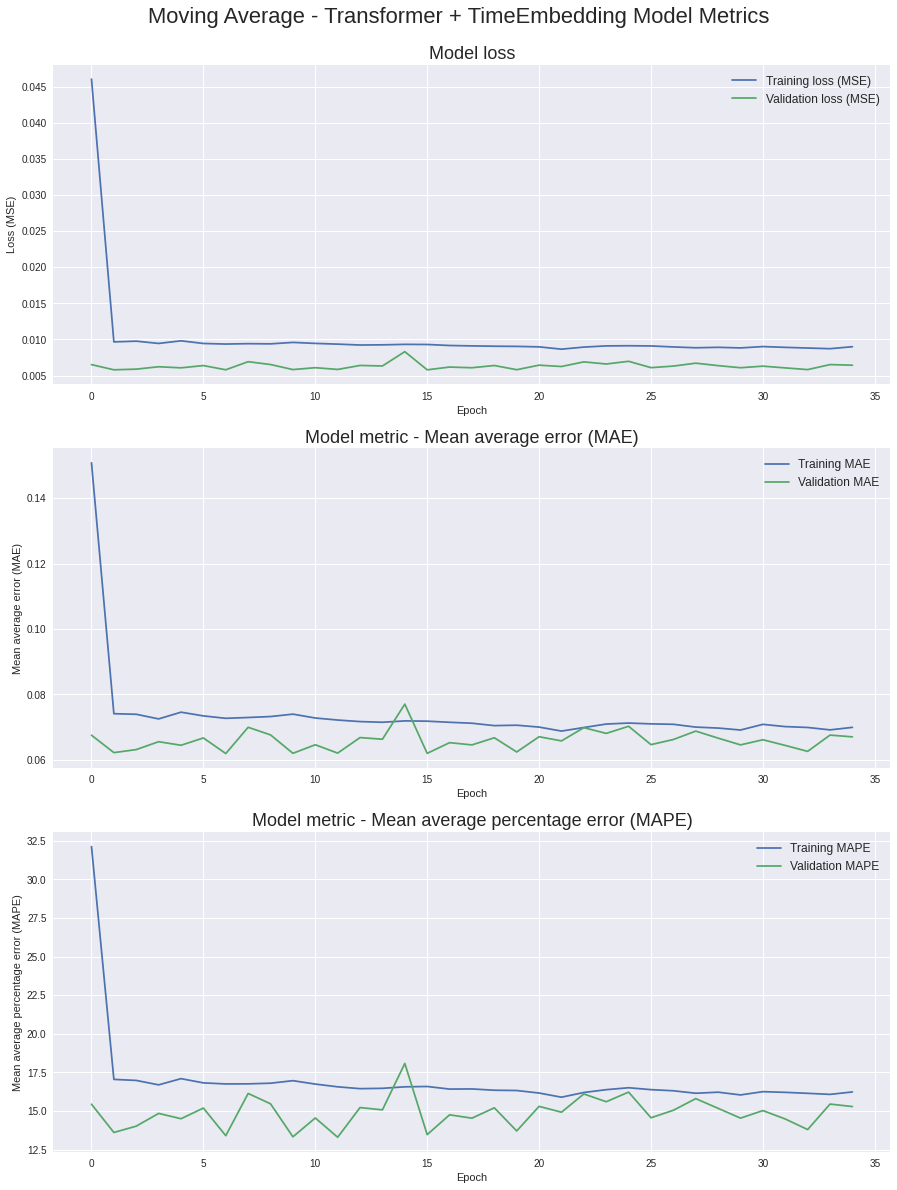

In [32]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)

In [68]:
model.save('transformer')

In [ ]:
X_train.shape

In [186]:
tmodel = load_model("transformer")

In [38]:
parent = pd.read_csv(Bitcoin_path, delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
print(max(parent['Close']))
print(min(parent['Close']))
def scaler(l):
  min = 178.102997
  max = 67566.828125
  pred = []
  for x in l:
    pred.append((x*(max - min) + min))
  return np.array(pred)

67566.828125
178.102997


In [181]:
print(min_return)
print(max_return)

-0.06512109971782276
0.07264907716666236


In [29]:
y_pred = scaler(list(model.predict(X_train).ravel()))
print(y_pred)

71/71 [==============================] - 65s 920ms/step
[29124.46340732 31053.84400333 28698.51446822 ... 28558.94082769
 30790.3095614  30659.44609367]


In [30]:
y_pred.shape

(2247,)

In [47]:
y_test.shape

(168,)

In [48]:
y_val.shape

(169,)

In [34]:
yy = y_train[0]
yy = yy *(67566.828125 - 178.102997) + 178.102997
print(yy)

33117.34529788091


In [33]:
from sklearn.metrics import r2_score
r2_score(y_test, model.predict(X_test))

6/6 [==============================] - 8s 1s/step


-0.002955002810944407

In [35]:
X_test_new = np.concatenate((X_val, X_test), axis = 0)

In [36]:
transformer_X_test_pred = model.predict(X_test_new)
transformer_X_train_pred = model.predict(X_train)

71/71 [==============================] - 65s 918ms/step


In [100]:
print(cnn_y_test_pred2[0])
print(transformer_X_test_pred[0])

49058.667969
[61233.93]


In [98]:
from sklearn.metrics import r2_score
r2_score(cnn_y_test_pred2, transformer_X_test_pred)

-0.6763450438159679

In [47]:
transformer_X_train_pred[0]

array([0.0027256], dtype=float32)

In [48]:
print(transformer_X_train_pred[0] * (0.06512109971782276 + 0.07264907716666236) - 0.06512109971782276)
tttt = transformer_X_train_pred[0] * (0.06512109971782276 + 0.07264907716666236) - 0.06512109971782276
print(transformer_X_train_pred[0] * (67566.828125 - 178.102997) + 178.102997)
print(tttt * (67566.828125 - 178.102997) + 178.102997)

[-0.06474559]
[361.77792]
[-4185.02]


In [39]:
transformer_X_test_pred = scaler(transformer_X_test_pred)
transformer_X_train_pred = scaler(transformer_X_train_pred)

In [51]:
transformer_X_test_pred[0]

array([61233.93], dtype=float32)

#CNN model

In [43]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D, MaxPooling2D, MaxPooling3D
from tensorflow.keras.layers import Dropout
import tensorflow as tf
import pickle
import pandas as pd
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint

In [42]:
%pip install pandas==1.5.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.2 MB 30.3 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


In [44]:
X_train, X_test = None, None
y_train, y_test = None, None
with open("data_X_train.pkl", 'rb') as f:
  X_train = pickle.load(f)
with open("data_X_test.pkl", 'rb') as f:
  X_test = pickle.load(f)
with open("data_X_val.pkl", 'rb') as f:
  X_val = pickle.load(f)
y_train = pd.read_pickle("data_y_train.pkl")
y_test = pd.read_pickle("data_y_test.pkl")
y_val = pd.read_pickle("data_y_val.pkl")

AttributeError: ignored

In [105]:
Y_train = y_train['BTC-USD_Close'].to_numpy()
Y_val = y_val['BTC-USD_Close'].to_numpy()
Y_test = y_test['BTC-USD_Close'].to_numpy()
Y_train_scaled = Y_train.copy()
print(Y_test.shape)
print(Y_val.shape)
Y_val_scaled = Y_val.copy()
Y_test_scaled = Y_test.copy()
#y_test = y_test['BTC-USD_Close'].to_numpy()

(171,)
(172,)


In [106]:
X_train.shape

(2271, 128, 3)

In [108]:
n_steps = 128
n_features = 1

In [109]:
filepath="./ckpts/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [110]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=2, activation='tanh', input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=2, activation='tanh', input_shape=(n_steps, n_features)))
model.add(Flatten())
model.add(Dense(100, activation='tanh'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

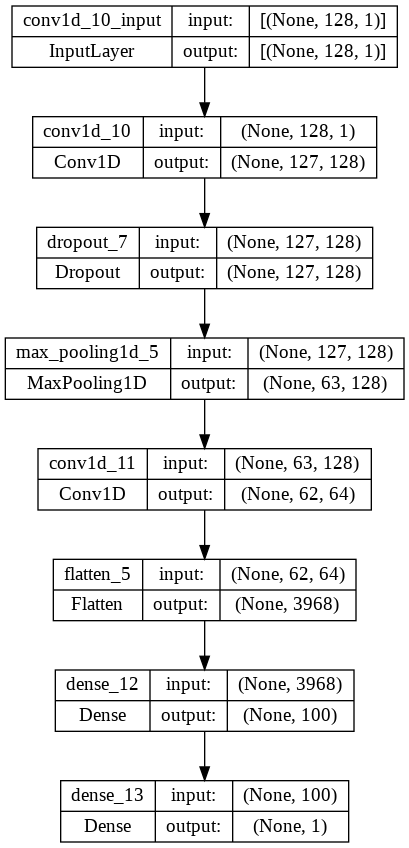

In [111]:
tf.keras.utils.plot_model(
    model,
    to_file="CNN.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96,)

In [112]:
X_train_new = X_train[:,:,1]
X_train_new = np.expand_dims(X_train_new, axis=2)
X_val_new = X_val[:,:,1]
X_val_new = np.expand_dims(X_val_new, axis=2)
X_test_new = X_test[:,:,1]
X_test_new = np.expand_dims(X_test_new, axis=2)

In [56]:
X_val_new.shape

(172, 128, 1)

In [57]:
model.fit(X_train_new, Y_train_scaled, 
          epochs=100, verbose=2, batch_size = 8, 
          validation_data = (X_val_new, Y_val_scaled), 
          callbacks = callbacks_list)

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.08526, saving model to ./ckpts/weights-improvement-01-0.09.hdf5
284/284 - 5s - loss: 0.0083 - val_loss: 0.0853 - 5s/epoch - 17ms/step
Epoch 2/100

Epoch 2: val_loss did not improve from 0.08526
284/284 - 3s - loss: 0.0031 - val_loss: 0.1697 - 3s/epoch - 12ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.08526 to 0.00583, saving model to ./ckpts/weights-improvement-03-0.01.hdf5
284/284 - 3s - loss: 0.0024 - val_loss: 0.0058 - 3s/epoch - 12ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.00583 to 0.00427, saving model to ./ckpts/weights-improvement-04-0.00.hdf5
284/284 - 3s - loss: 0.0011 - val_loss: 0.0043 - 3s/epoch - 12ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 0.00427
284/284 - 3s - loss: 8.3088e-04 - val_loss: 0.0043 - 3s/epoch - 11ms/step
Epoch 6/100

Epoch 6: val_loss did not improve from 0.00427
284/284 - 3s - loss: 7.1001e-04 - val_loss: 0.0076 - 3s/epoch - 12ms/step
Epoch 7/100

Epoch 7: val_loss

In [58]:
def scaler(l):
  min = 178.102997
  max = 67566.828125
  pred = []
  for x in l:
    pred.append((x*(max - min) + min))
  return np.array(pred)

In [113]:
from keras.models import load_model

In [114]:
model_final = load_model('./ckpts/weights-improvement-15-0.00.hdf5')

In [115]:
y_pred = model_final.predict(X_test_new)

6/6 [==============================] - 0s 7ms/step


In [22]:
from sklearn.metrics import r2_score

In [79]:
r2_score(Y_test_scaled, y_pred)

0.5788744422894829

In [116]:
X_test_new_1 = np.concatenate((X_val_new, X_test_new), axis = 0)

In [117]:
cnn_x_train_predict = model_final.predict(X_train_new)
cnn_x_test_predict = model_final.predict(X_test_new_1)

11/11 [==============================] - 0s 12ms/step


In [159]:
def scaler(l):
  min = 178.102997
  max = 67566.828125
  pred = []
  for x in l:
    pred.append((x*(max - min) + min))
  return np.array(pred)

In [118]:
cnn_x_test_predict = scaler(cnn_x_test_predict)
cnn_x_train_predict = scaler(cnn_x_train_predict)

In [119]:
y_test_new_cnn = np.concatenate((Y_val_scaled, Y_test_scaled), axis = 0)

In [120]:
y_test_new_cnn.shape

(343,)

In [121]:
cnn_y_train_predict = scaler(Y_train_scaled)
cnn_y_test_pred = scaler(Y_test_scaled)
cnn_y_test_pred2 = np.concatenate((scaler(Y_val_scaled), scaler(Y_test_scaled)), axis = 0)

In [103]:
#transformer_X_test_pred = transformer_X_test_pred
#transformer_X_train_pred = scaler(transformer_X_train_pred)

In [122]:
print(cnn_x_train_predict.shape)
print(transformer_X_train_pred.shape)

(2271, 1)
(2271, 1)


In [123]:
print(cnn_x_test_predict.shape)
print(transformer_X_test_pred.shape)

(343, 1)
(343, 1)


#Stacking the model prediction

In [126]:
X_train_new2 = np.concatenate((transformer_X_train_pred, cnn_x_train_predict), axis = 1)
y_train_new = cnn_y_train_predict
X_test_new2 = np.concatenate((transformer_X_test_pred, cnn_x_test_predict), axis = 1)
y_test_new = cnn_y_test_pred2

In [127]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train_new2, y_train_new)
y_pred_new = reg.predict(X_test_new2)

In [129]:
print(reg.score(X_test_new2, y_test_new))

0.9644967096867669


In [130]:
r2_score(y_pred_new, y_test_new)

0.9535721275535208

In [131]:
filename = 'finalized_lr_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [133]:
import xgboost as xgb

In [135]:
xgbm = xgb.XGBRegressor()

In [136]:
xgbm.fit(X_train_new2, y_train_new)

[19:39:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [137]:
y_pred_xgb = reg.predict(X_test_new2)

In [138]:
r2_score(y_pred_xgb, y_test_new)

0.9535721275535208

In [132]:
from sklearn import metrics
print(metrics.mean_squared_error(y_pred_new, y_test_new))

9278655.051192882


In [29]:
tmp = pd.read_csv('BTC-USD.csv')

In [30]:
tmp.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [31]:
max_x, min_c = max(tmp['Close']), min(tmp['Close'])

In [32]:
print(max_x, min_c)

67566.828125 178.102997


In [168]:
print(tmp.loc[128,:])

Date         2015-01-23
Open         233.516998
High         234.845001
Low          225.195999
Close        232.878998
Adj Close    232.878998
Volume         24621700
Name: 128, dtype: object


In [86]:
!zip -r ckpts_cnn.zip ckpts
from google.colab import files
files.download("ckpts_cnn.zip")

  adding: ckpts/ (stored 0%)
  adding: ckpts/weights-improvement-06-0.00.hdf5 (deflated 8%)
  adding: ckpts/weights-improvement-04-0.01.hdf5 (deflated 8%)
  adding: ckpts/weights-improvement-55-0.00.hdf5 (deflated 8%)
  adding: ckpts/weights-improvement-01-0.41.hdf5 (deflated 8%)
  adding: ckpts/weights-improvement-13-0.00.hdf5 (deflated 7%)
  adding: ckpts/weights-improvement-05-0.01.hdf5 (deflated 7%)
  adding: ckpts/weights-improvement-02-0.11.hdf5 (deflated 8%)
  adding: ckpts/weights-improvement-03-0.11.hdf5 (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [139]:
y_train_pred_stack = reg.predict(X_train_new2)
y_test_pred_stack = reg.predict(X_test_new2)

In [93]:
y_train_new.shape[0]

2271

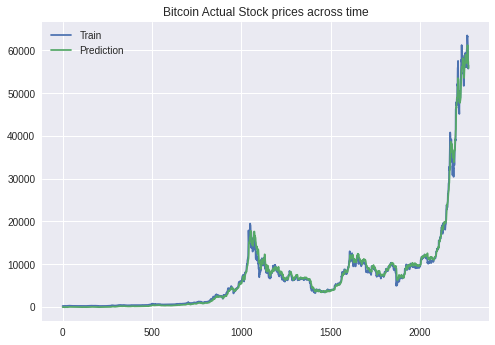

In [140]:
ax = plt.subplot()
ax.plot(range(y_train_new.shape[0]), y_train_new, label = 'Train')
ax.plot(range(y_train_new.shape[0]), y_train_pred_stack, label = 'Prediction')
ax.set_title('Bitcoin Actual Stock prices across time')
ax.legend()
plt.show()

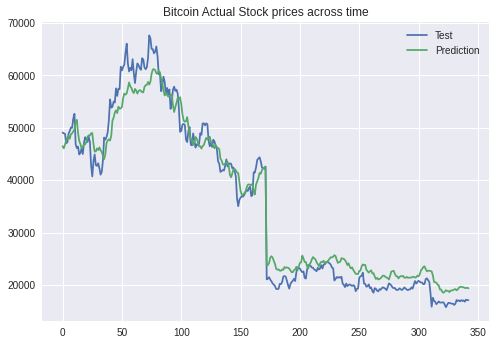

In [141]:
ax = plt.subplot()
ax.plot(range(y_test_new.shape[0]), y_test_new, label = 'Test')
ax.plot(range(y_test_new.shape[0]), y_test_pred_stack, label='Prediction')
ax.set_title('Bitcoin Actual Stock prices across time')
ax.legend()
plt.show()